# Gaussian Mixture Model (NIR beers dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import models as mdl
import utils as utl
from data import Data

## Model configuration

In [3]:
# model mode
model_mode      = 'training'

# data filenames
#data_filename   = '../../data/beers/NIR_beers.csv'
data_filename   = '../../code/test/dummy_data_e.csv'
trace_filename  = './traces/trace_beers_nir_constant'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)   
data_obj.data.head(5)
data = data_obj.data
data.head(5)

,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,...,392.0,393.0,394.0,395.0,396.0,397.0,398.0,399.0,400.0,label
27,7.604182,7.794325,7.579148,7.603808,7.558174,7.565965,7.608290,7.759727,7.611851,7.813031,...,7.970374,7.925680,7.789761,7.723024,7.476367,7.718870,7.897576,7.681353,7.668456,A
15,8.644627,8.875970,8.594583,8.637776,8.706313,8.715218,8.847422,8.750700,8.589368,8.683395,...,8.955750,8.950957,8.848445,8.782508,8.723359,8.726334,8.757898,8.744109,8.764436,A
23,1.408405,1.168257,1.270898,1.372129,1.270265,1.162953,1.197512,1.136584,0.937855,1.337083,...,1.488678,1.388101,1.350594,1.336871,1.277094,1.412796,1.382820,1.163533,1.309557,B
17,8.905912,8.642811,8.645653,8.767581,8.794781,8.662547,8.599669,8.736374,8.653193,8.743859,...,8.928449,9.076865,8.795962,8.802991,8.735554,8.832670,8.845886,8.801673,8.707186,A
8,12.314894,12.337808,12.138682,12.123637,12.410821,12.204763,12.169967,12.249364,12.162356,12.211371,...,12.598710,12.653384,12.368777,12.402698,12.368705,12.442228,12.460986,12.277805,12.384506,A


A: blue
B: red


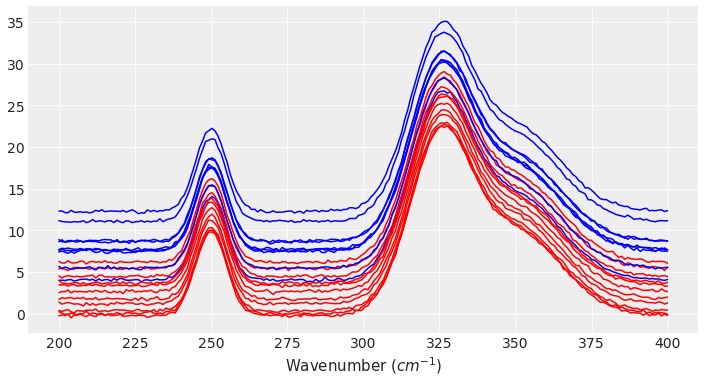

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# number of classes
nclasses = len(class_labels)

# plot dataframe
utl.plot_data(data_obj, 20)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

A    15
B    15
Name: label, dtype: int64


In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data_obj.data, train_size=0.5, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(15, 201)

In [9]:
train_data.shape

(15, 201)

# Model definition
The following model is assumed:

\begin{equation}
\large A_{m} \sim \text{U} (0, max(Y)) \\
\large \mu_{m} \sim \mathcal{N}(\mu_{m}, 50) \\
\large \sigma_{m} \sim |\mathcal{N}(0, 100)| \\
\large \epsilon \sim |\mathcal{N}(0, 1)| \\
\large \theta = \sum\limits_{m=1}^M [A_m \cdot e^{-\frac{(x_n-\mu_m)^2}{2\cdot\sigma_m^2}}] + a_0 \\
\large y \sim \mathcal{N}(\theta, \epsilon)
\end{equation}

In [10]:
# 1D array of X values
len_x = len(train_data.columns[:data_obj.non_data_columns])
x_val = np.array(train_data.columns[:data_obj.non_data_columns], dtype='float32').reshape(len_x,1)

# store the data values for all different classes
df = [train_data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

x_n = train_data.columns[:data_obj.non_data_columns]
x_s = [df[i][x_n].values for i in range(len(df))]

In [11]:
# load model and run inference
nsamples = 5
model_gc = mdl.model_gauss_constant(observations=x_s, nclasses=len(class_labels), 
                                    xvalues=x_val, npeaks=3, nsamples=nsamples)

with model_gc:
    trace_gc = pm.sample(2000, init='adapt_diag', tune=1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, a_1, a_0, sigma_a, sigma_aa, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [03:52<00:00, 25.85draws/s] 
The acceptance probability does not match the target. It is 0.8833926394011921, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.91361036553463, but should be close to 0.8. Try to increase the number of tuning steps.


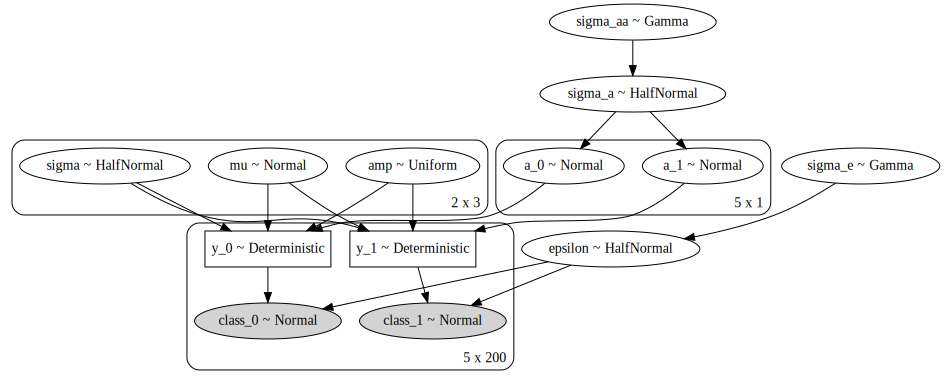

In [12]:
pm.model_to_graphviz(model_gc)

# Model evaluation

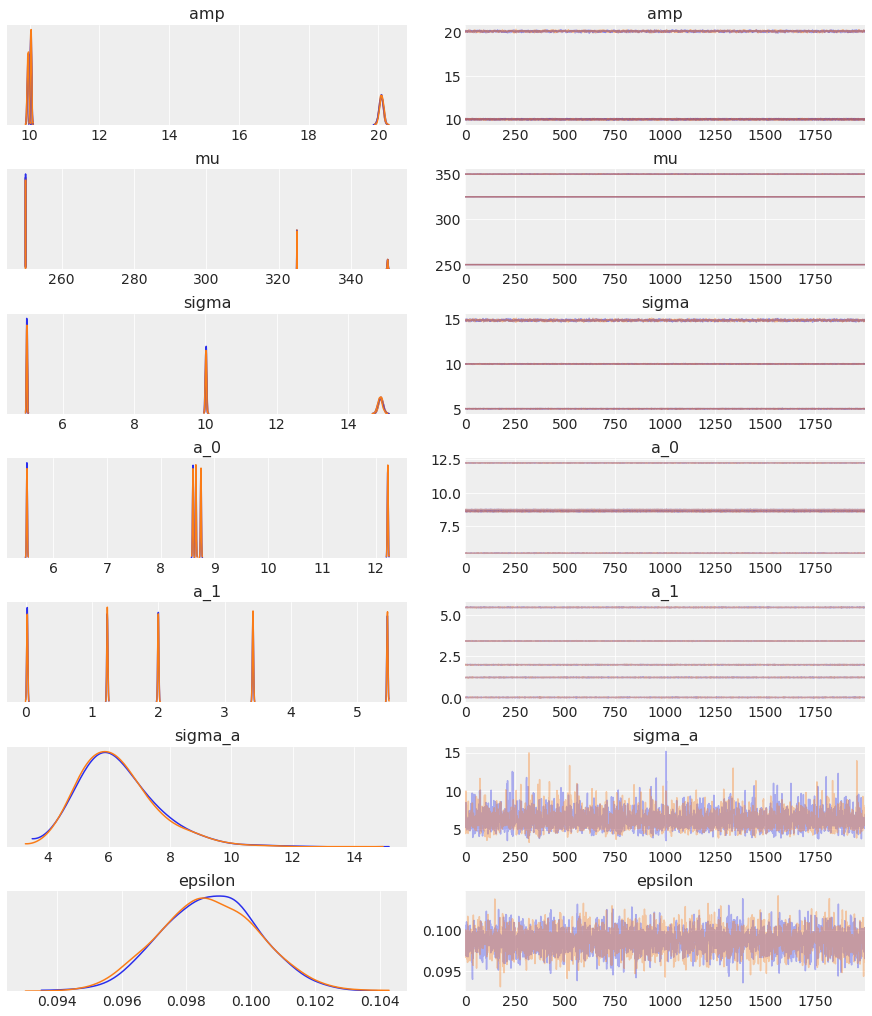

In [13]:
varnames = ['amp', 'mu', 'sigma', 'a_0', 'a_1', 'sigma_a', 'epsilon']
az.plot_trace(trace_gc, varnames, compact=True);

In [14]:
#az.plot_posterior(trace_gc, varnames);

In [15]:
ppc_mm = pm.sample_posterior_predictive(trace_gc, samples=500, model=model_gc)

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:02<00:00, 205.71it/s]


In [16]:
ppc_prior_mm = pm.sample_prior_predictive(samples=500, model=model_gc)

arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


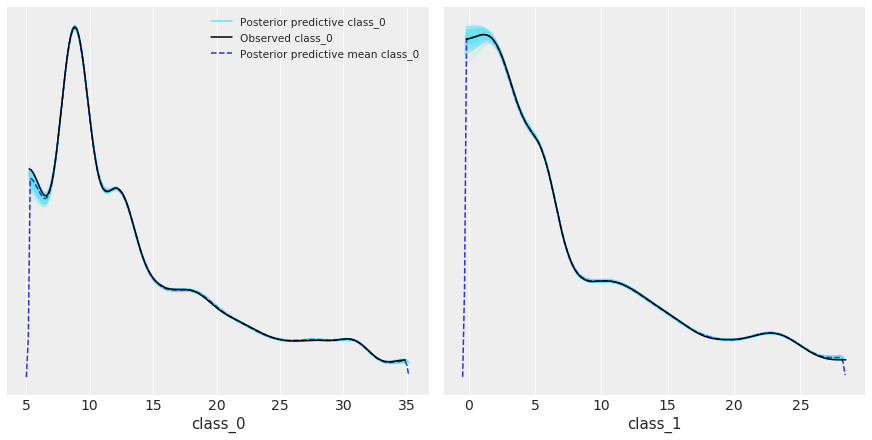

In [17]:
data_ppc = az.from_pymc3(trace=trace_gc, posterior_predictive=ppc_mm)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

In [18]:
x_val = x_val.reshape(len(x_val),)

In [43]:
for i in range(5):
    print(trace_gc['sigma'][i][1])

[ 5.00573233 10.01573906 14.8825126 ]
[ 5.00988332 10.02301252 14.89458226]
[ 4.98176743 10.02715804 14.85379852]
[ 4.98567723 10.03079583 14.77346097]
[ 4.99584213 10.0397004  14.79172994]


In [44]:
for i in range(5):
    print(trace_gc['a_0'][i])

[[ 8.63950232]
 [ 8.59356696]
 [ 8.74672394]
 [ 5.51274436]
 [12.23485896]]
[[ 8.6338431 ]
 [ 8.60315082]
 [ 8.74542968]
 [ 5.50278784]
 [12.21443427]]
[[ 8.67857071]
 [ 8.60494173]
 [ 8.74787578]
 [ 5.52488535]
 [12.23909723]]
[[ 8.67483436]
 [ 8.60317057]
 [ 8.75106391]
 [ 5.52271107]
 [12.2494228 ]]
[[ 8.64021551]
 [ 8.60830311]
 [ 8.75309962]
 [ 5.50654509]
 [12.20931758]]


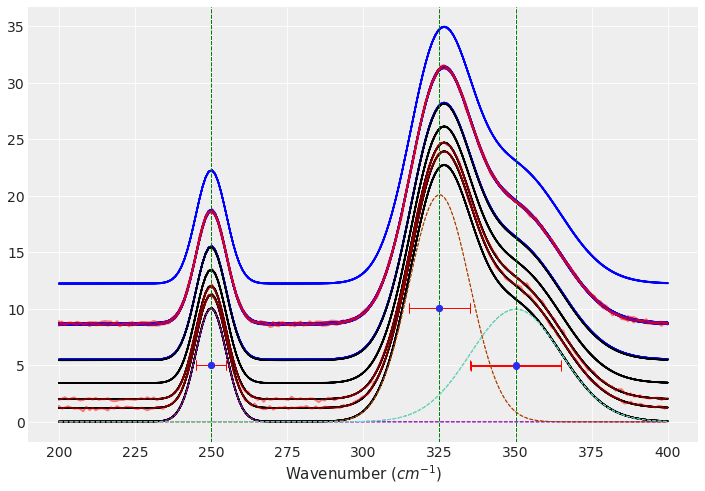

In [37]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set(xlabel='Wavenumber ($cm^{-1}$)')

# plot samples from the posterior
#sp0 = ppc_mm['class_0']
#sp1 = ppc_mm['class_1']
#for i in range(5):
#    plt.plot(x_val, sp0[-i,i,:], '-', color="black", alpha=.2)
#    plt.plot(x_val, sp1[i,i,:], '-', color="blue", alpha=.2)
    
for z in range(10):
    for i in range(5):
        plt.plot(x_val, trace_gc['y_0'][z,i,:], '-', color='blue', alpha=1)
        plt.plot(x_val, trace_gc['y_1'][z,i,:], '-', color='black', alpha=1)
    
# plot samples from the prior
#sp0 = ppc_prior_mm['class_0']
#sp1 = ppc_prior_mm['class_1']
#for i in range(5):
#    plt.plot(x_val, sp0[-i,i,:], '-', color="blue", alpha=.2)
#    plt.plot(x_val, sp1[-i,i,:], '-', color="blue", alpha=.2)
    
# plot 94% HPD interval
#az.plot_hpd(x_val, ppc_mm['class_0'], smooth=False, credible_interval=0.94, color='C1')
#az.plot_hpd(x_val, ppc_mm['class_1'], smooth=False, credible_interval=0.94, color='C2')

# plot mixture components 
A = trace_gc['amp'].mean(axis=0).flatten()
M = trace_gc['mu'].mean(axis=0).flatten()
S = trace_gc['sigma'].mean(axis=0).flatten()
for j in range(len(A)):
    Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
    plt.plot(x_val, Y, '--', linewidth=1)
    plt.axvline(M[j], linestyle='--', linewidth=1, color='g')
    plt.errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                     ecolor='r', elinewidth=1, capsize=5, capthick=1)
    
# plot samples from the dataset
for i in range(5):
    y_val = train_data.values[i]
    plt.plot(x_val, y_val[:data_obj.non_data_columns], '-', color="red", alpha=.5, linewidth=2)

In [38]:
az.r2_score(x_s[0][:nsamples], ppc_mm['class_0'])

r2        0.999796
r2_std    0.000013
dtype: float64

In [39]:
az.r2_score(x_s[1][:nsamples], ppc_mm['class_1'])

r2        0.999792
r2_std    0.000014
dtype: float64

In [40]:
varnames = ['amp', 'mu', 'sigma', 'a_0', 'a_1', 'sigma_a', 'epsilon']
az.summary(trace_gc, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"amp[0,0]",10.032,0.018,9.999,10.069,0.000,0.000,4102.0,4102.0,4107.0,3078.0,1.0
"amp[0,1]",20.078,0.058,19.970,20.190,0.002,0.001,1375.0,1375.0,1381.0,2017.0,1.0
"amp[0,2]",9.966,0.024,9.921,10.010,0.001,0.000,1493.0,1493.0,1492.0,2304.0,1.0
"amp[1,0]",10.038,0.018,10.005,10.073,0.000,0.000,4562.0,4562.0,4518.0,3060.0,1.0
"amp[1,1]",20.092,0.060,19.982,20.204,0.002,0.001,1237.0,1237.0,1242.0,2190.0,1.0
"amp[1,2]",9.952,0.024,9.906,9.996,0.001,0.000,1370.0,1370.0,1373.0,2267.0,1.0
"mu[0,0]",250.018,0.010,249.999,250.038,0.000,0.000,4370.0,4370.0,4358.0,2650.0,1.0
"mu[0,1]",325.046,0.024,325.000,325.091,0.001,0.000,1332.0,1332.0,1332.0,1953.0,1.0
"mu[0,2]",350.146,0.098,349.950,350.323,0.003,0.002,1305.0,1305.0,1307.0,1743.0,1.0
"mu[1,0]",249.998,0.010,249.978,250.017,0.000,0.000,5466.0,5466.0,5519.0,2524.0,1.0


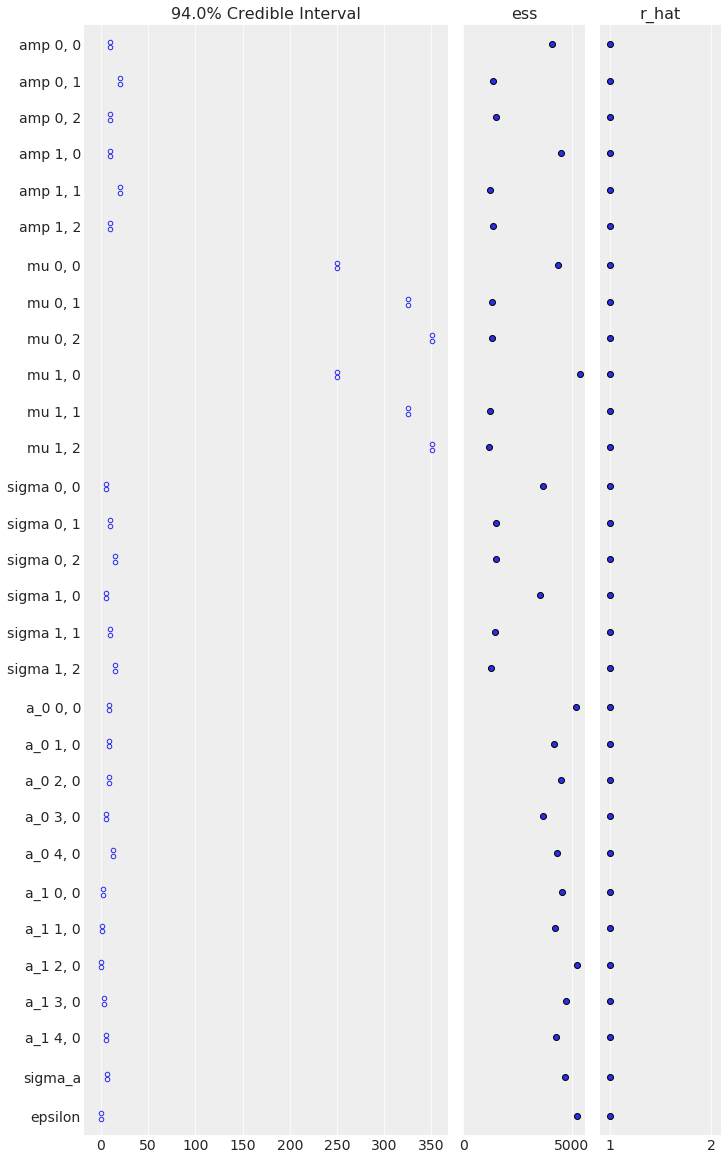

In [41]:
az.plot_forest(trace_gc, var_names = varnames, r_hat=True, ess=True);

## Save results

In [42]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, trace_gc)